In [8]:
from graph_ds import PyH3Graph
from pois_to_h3 import get_pois_h3
from ghsl_processing import get_origins, city_boundaries_to_h3 

import pandas as pd
import h3.api.numpy_int as h3
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np
import seaborn as sns
import pickle


def plot_hex_df(df, markersize, color_column=None, color_categorical=False):
    df[['y','x']] = list(df['h3_index'].apply(h3.h3_to_geo))
    # Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))

    fig, ax = plt.subplots(figsize=(10,10))
    # Show the GeoPandas DataFrame

    if color_column:
        gdf.plot(ax=ax, column=color_column, categorical=color_categorical,
                  legend=True, markersize=markersize, alpha=0.5, cmap='Reds',
                  vmin=0, vmax=25)
    else:
        gdf.plot(ax=ax, markersize=markersize, alpha=0.5)

    #plt.xlim(12.391681,12.737388)
    #plt.ylim(55.549206, 55.759991)

    cx.add_basemap(ax = ax, crs="EPSG:4326")
    #plt.show()

def routing(category_set, origins, destinations, num_origins, graph):
    # get residential origins, sample with replacement
    origins = list(origins[origins['residential_bool']==1].sample(num_origins, replace=True)['h3_index'])

    mins={}
    category_travel_time_means = {}
    for c in category_set:
        cat_destinations = list(destinations[destinations['category']==c]['h3_index'])
        ds = graph.matrix_distance(origins=origins, destinations=cat_destinations, dynamic_infinity=True)

        # they might be different lengths, so we can't use a df
        mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}
        category_travel_time_means[c] = np.nanmean(list(mins[c].values()))

    return category_travel_time_means, mins

def plot_accessibility(df, municipality, poi):
    # get rows which contain a specific municipality
    area = '_'.join(municipality)
    # get rows which contain a specific municipality and category
    plot_df = df[df['municipality'] == area]
    plot_df = plot_df[plot_df['category'] == poi]
    plot_df[['y','x']] = list(plot_df['h3_index'].apply(h3.h3_to_geo))
    # Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
    gdf = gpd.GeoDataFrame(plot_df, geometry=gpd.points_from_xy(plot_df.x, plot_df.y))
    fig, ax = plt.subplots(figsize=(10,10))
    gdf.plot(ax=ax, column='travel_time', categorical=False,
            legend=True, markersize=50, alpha=0.5, cmap='Reds',
                vmin=0, vmax=25, 
                legend_kwds={'label': "Travel time (minutes)", 'shrink':0.3})

    # Load and plot POI locations
    destinations = pd.read_csv('../resources/destinations/'+area+'_destinations_clean.csv')
    poi_df = destinations[destinations['category']==poi].copy()
    poi_df[['y','x']] = list(poi_df['h3_index'].apply(h3.h3_to_geo))
    # Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
    gdf = gpd.GeoDataFrame(poi_df, geometry=gpd.points_from_xy(poi_df.x, poi_df.y))
    gdf.plot(ax=ax, markersize=5, alpha=0.5)

    # Add title and basemap
    plt.title(f"{area} min travel time from residential origins (red) to {poi}s (in blue) - {len(plot_df)} origins")
    cx.add_basemap(ax = ax, crs="EPSG:4326")


def calculate_bike_and_transit_benefit(results_df, quantiles=[1,2,3,4,5]):
    # compare mean of graph current to mean of graph walk+bike
    # get the mean of the mean travel time for each municipality for each graph type
    plotting_results_mean = results_df[results_df['population_density_quantile'].isin(quantiles)].groupby(['graph']).mean(numeric_only=True).reset_index()
    walk_and_bike = plotting_results_mean[plotting_results_mean['graph']=='Walk and Bike']['mean_farthest_travel_time'].values[0]
    current = plotting_results_mean[plotting_results_mean['graph']=='All']['mean_farthest_travel_time'].values[0]
    walk_and_transit = plotting_results_mean[plotting_results_mean['graph']=='Walk and Transit']['mean_farthest_travel_time'].values[0]
    ideal_bike = plotting_results_mean[plotting_results_mean['graph']=='Improved Bike']['mean_farthest_travel_time'].values[0]
    ideal_transit = plotting_results_mean[plotting_results_mean['graph']=='Improved Transit']['mean_farthest_travel_time'].values[0]

    print('population density quantiles:', quantiles)
    print(f"transit contributes to a {round(((current/walk_and_bike)-1)*100,3)}% decrease in travel time over walking and biking")
    print(f"bikes contribute to a {round(((current/walk_and_transit)-1)*100,3)}% decrease in travel time over walking and transit")
    print(f"Ideal biking infrastructure would contribute to a {round(((current/ideal_bike)-1)*-100,3)}% decrease in travel time over current infrastructure")
    print(f"reducing transit wait times would contribute to a {round(((current/ideal_transit)-1)*-100,3)}% decrease in travel time over current infrastructure")


In [9]:
# get bbox for all of these cities so that I can extract bbbike data
code_mappings: dict = {
    '846': 'Mariagerfjord Kommune',
    '741': 'Samsø Kommune',
    '760': 'Ringkøbing-Skjern Kommune',
    '710': 'Favrskov Kommune',
    '480': 'Nordfyns Kommune',
    '492': 'Ærø Kommune',
    '270': 'Gribskov Kommune',
    '730': 'Randers Kommune',
    '450': 'Nyborg Kommune',
    '169': 'Høje-Taastrup Kommune',
    '621': 'Kolding Kommune',
    '250': 'Frederikssund Kommune',
    '147': 'Frederiksberg Kommune',
    '230': 'Rudersdal Kommune',
    '155': 'Dragør Kommune',
    '101': 'København Kommune',
    '147': 'Frederiksberg Kommune',
    '825': 'Læsø Kommune',
    '550': 'Tønder Kommune',
    '665': 'Lemvig Kommune',
    '760': 'Ringkøbing-Skjern Kommune',
}

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [10]:
# Inputs
# municipality names
# municipailties are lists because you can add many into one analysis
municipalities = [[x] for x in code_mappings.values()]
# public transport
gtfs_paths = [["../resources/rejseplanen_GTFS.zip"]]*len(municipalities)
# ghsl data for building types
#tif_paths = ['../resources/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19_Denmark.tif', '../resources/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19_Denmark.tif']
tif_paths = ['../resources/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19_Denmark.tif']*len(municipalities)

In [11]:
# Parameters

# 12 is around 10 meter resolution
H3_RES = 12

# how many origins to sample
num_origins = 1000

#essential filter will be the least restrictive
essential_filter = {
    "amenity":["pharmacy","dentist","clinic","doctors","school","library"],
    "shop":["supermarket","greengrocer","medical_supply","grocery","wholesale"],
    "healthcare":["clinic","doctor","pharmacy","dentist"],
    "leisure":["park","fitness_centre",'fitness_station'], 
    "sport":['tennis','soccer','swimming_pool','sports_centre','pitch','track','golf_course','gymnastics','gym','fitness_centre','fitness_station']
    }

# categories considered for the n-minute calculation
category_set = ['pharmacy','park','supermarket','sport', 'school','library']

# how to map osm tags to categories
osm_tag_mapping = {
    "medical_supply":"pharmacy",
    "greengrocer":"supermarket",
    "wholesale":"supermarket",
    "grocery":"supermarket",
    "clinic":"doctor",
    "doctors":"doctor",
    'pitch':'sport',
    'track':'sport',
    'sports_centre':'sport',
    'fitness_centre':'sport',
    'fitness_station':'sport'
}

In [12]:
# osm file processing
osm_names = ['_'.join(x)+'_processed.osm.pbf' for x in municipalities]
relative_path_osm = "../resources/osm/"
osm_paths = [relative_path_osm + x for x in osm_names]

In [6]:
# pipeline
results={}
for i,municipality in enumerate(municipalities):

    # which cities do we want?, make sure your PBF file contains these cities!!!
    # use the bounding box returned here to make your pbf crop on extract.bbbikes.org
    print(f"getting boundaries for {municipality}")
    city_bounds_h3, bbox, bbox_pois = city_boundaries_to_h3(municipality)
    
    # get origins (save for later)
    print(f"getting origins for {municipality}")
    origins = get_origins(H3_RES, municipality, bbox, tif_paths[i], city_bounds_h3)

    # get destinations (save for later)
    print(f"getting destinations for {municipality}")
    destinations = get_pois_h3(osm_paths[i], essential_filter, H3_RES, category_set, osm_tag_mapping, municipality)

    key = "_".join(municipality)
    results[key]={}
    print(f"Routing for {municipality}:")
    for g in ['all', 'walk', 'walk+bike', 'walk+transit','bike_ideal','transit_ideal']:
        print(g)
        # build the graph
        if g=='bike_ideal':
            wait_time_multiplier=1.0
            walk_speed=4.5
            layer = 'walk+transit'
        elif g=='transit_ideal':
            wait_time_multiplier=0.33
            walk_speed=1.4
            layer = 'all'
        else:
            wait_time_multiplier=1.0
            walk_speed=1.4
            layer=g

        weight_options = {'bike_penalty': 1.0,
                            'wait_time_multiplier': wait_time_multiplier,
                            'walk_speed': walk_speed,
                            'bike_speed': 4.5}
        
        graph = PyH3Graph(weight_options=weight_options, k_ring=2, layers=layer)
        graph.create(osm_path=osm_paths[i],gtfs_paths=gtfs_paths[i])

        # do routing
        category_means, route_mins = routing(category_set, origins, destinations, num_origins, graph)
        # save results as dictionary
        results[key].update({g:route_mins})


getting boundaries for ['Mariagerfjord Kommune']


In [ ]:
# save dictionary .pkl file
with open('../resources/model_run_all_denmark.pkl', 'wb') as fp:
    pickle.dump(results, fp)
    print('dictionary saved successfully to file')

In [13]:
# load dictionary .pkl file
with open('../resources/model_run_all_denmark_more_sport.pkl', 'rb') as fp:
    results = pickle.load(fp)
    print('dictionary successfully loaded')

dictionary successfully loaded


# Calculate N-minute

In [14]:
# operations: mean_all_locations(max_category(min travel time to each category))
# get analysis format
plotting_results = []
# for each municipality, for each graph type, get the mean travel time
for m in results.keys():
    # loop over graph types
    for g in results[m].keys():
        # loop over categories
        # remove libraries from the df, we don't want to include them in the calculation
        df_max = pd.DataFrame(results[m][g]).drop('library',axis=1)
        df_max = df_max.max(axis=1)
        # calculate the 5th and 95th percentiles
        # calculate the 5th and 95th percentiles for each column
        #low_quantile = df_max.quantile(0.05)
        #high_quantile = df_max.quantile(0.95)

        # exclude values outside of the desired percentiles
        #max_filtered = df_max.loc[(df_max > low_quantile) & (df_max < high_quantile)]

        # calculate the mean of the filtered Series
        #mean_filtered = max_filtered.mean()
        # take the median of all rows
        median_df = df_max.median()
        

        plotting_results.append((m,g,median_df))

plotting_results = pd.DataFrame(plotting_results,
 columns=['municipality','graph','mean_farthest_travel_time'])

In [15]:
# add population density information
pop_density = pd.read_csv('../resources/denmark_pop_density_sample.csv').sort_values(
    by='population_density', ascending=False)
# join the two dataframes on municipality name
plotting_results = plotting_results.merge(pop_density, on='municipality')
plotting_results = plotting_results.sort_values(by='population_density', ascending=False)
density_map = pop_density[['municipality','population_density']].set_index('municipality')

In [16]:
# rename the graph types
graph_label_map = {'current':'All','transit_ideal':'Improved Transit',
                    'walk+transit':'Walk and Transit', 'walk+bike': 'Walk and Bike', 'walk':'Walk', 'all':'All',
                     'bike_ideal':'Improved Bike'}
plotting_results['graph'] = plotting_results['graph'].map(graph_label_map)

# add 2 minutes to ideal bike
postprocess_bike_penalty_results = plotting_results.copy()
postprocess_bike_penalty_results.loc[postprocess_bike_penalty_results['graph']=='Improved Bike','mean_farthest_travel_time'] += 2

In [17]:
plotting_results['municipality'].unique()

array(['Frederiksberg Kommune', 'København Kommune', 'Dragør Kommune',
       'Rudersdal Kommune', 'Høje-Taastrup Kommune',
       'Frederikssund Kommune', 'Kolding Kommune', 'Gribskov Kommune',
       'Randers Kommune', 'Nyborg Kommune', 'Favrskov Kommune',
       'Ærø Kommune', 'Nordfyns Kommune', 'Mariagerfjord Kommune',
       'Ringkøbing-Skjern Kommune', 'Lemvig Kommune', 'Samsø Kommune',
       'Tønder Kommune', 'Læsø Kommune'], dtype=object)

In [ ]:
# plot the results as a scatter with each municipality on the x, travel time on the y, and graph type as color
fig, ax = plt.subplots(figsize=(5,10))
             
sns.scatterplot(data=plotting_results, x='mean_farthest_travel_time', y='municipality', hue='graph', alpha=0.7, palette='colorblind', legend=True)
plt.legend(title='Network Type', frameon=False)
# add legend as line underneath chart
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=4, title='Owner Rank', frameon=False)
# rotate the x labels
#plt.xticks(rotation=45)
plt.xlabel('N-minute travel time (minutes)')
plt.ylabel('Municipality')
#plt.title('N-minute travel time across Denmark for different graph types')
# add custom legend labels

In [21]:
custom_colors = ['#00D3E5','blue','purple','red','orange', '#EAEA00']  

In [ ]:
# plot the results as a scatter with each municipality on the x, travel time on the y, and graph type as color
plt.figure(figsize=(5,10))
sns.scatterplot(data=postprocess_bike_penalty_results, x='mean_farthest_travel_time', y='municipality', hue='graph', alpha=0.8, palette=custom_colors)
# rotate the x labels
#plt.xticks(rotation=45)
plt.xlabel('N-minute travel time (minutes)')
plt.ylabel('Municipality')
#plt.title('N-minute travel time across Denmark for different graph types')
plt.legend(title='Network Type', frameon=False, bbox_to_anchor=(1.2, -0.1), ncol=3)

# save a high res version
plt.savefig('figures/denmark_travel_time_scatter.png', dpi=300, bbox_inches='tight')

# NOTE
Sometimes 'walk + bike' seems to outperform 'all'. We think this is due to there being destinations which are only accessible via public transports (eg. airports).  When the walk + bike networks is unable to reach a destination, this value is not considered in the calculation. - we should check how many nans we are getting!

In [ ]:
postprocess_bike_penalty_results.head(2)

In [ ]:
diffs=[]
for k,v in postprocess_bike_penalty_results.groupby('municipality'):
    walk_and_bike = v[v['graph']=='Walk and Bike']['mean_farthest_travel_time'].values[0]
    current = v[v['graph']=='All']['mean_farthest_travel_time'].values[0]
    walk_and_transit = v[v['graph']=='Walk and Transit']['mean_farthest_travel_time'].values[0]
    ideal_bike = v[v['graph']=='Improved Bike']['mean_farthest_travel_time'].values[0]
    ideal_transit = v[v['graph']=='Improved Transit']['mean_farthest_travel_time'].values[0]
    diffs.append([k, ((current/walk_and_bike)-1)*-100, ((current/walk_and_transit)-1)*-100, ((ideal_bike/current)-1)*-100, ((ideal_transit/current)-1)*-100])

#diffs = pd.DataFrame(diffs, columns=['municipality','walk_and_bike','walk_and_transit','ideal_bike','ideal_transit'])
diffs = pd.DataFrame(diffs, columns=['municipality','Transit Benefit','Bicycle Benefit', 'Benefit of Improved Bicycle', 'Benefit of Improved Transit'])
# melt the dataframe
#diffs_melt = pd.melt(diffs, id_vars=['municipality'], value_vars=['walk_and_bike','walk_and_transit','ideal_bike','ideal_transit'])
diffs_melt = pd.melt(diffs, id_vars=['municipality'], value_vars=['Transit Benefit','Bicycle Benefit'])

order = postprocess_bike_penalty_results['municipality'].unique()
# reorder the dataframe by population density
diffs_melt = diffs_melt.set_index('municipality').loc[order].reset_index()
# rename the columns
diffs_melt.columns = ['municipality','Network Type','Travel Time Percentage']
# plot
plt.figure(figsize=(5,5))
sns.scatterplot(data=diffs_melt, x='Travel Time Percentage', y='municipality', hue='Network Type', alpha=0.8, palette='colorblind')

plt.legend(frameon=False)

In [ ]:
diffs.columns

In [ ]:
print(diffs['Transit Benefit'].mean())
print(diffs['Bicycle Benefit'].mean())

In [ ]:
# make font helvetica
#plt.rcParams['font.family'] = 'helvetica'
# increase font size
plt.rcParams.update({'font.size': 15})

order = postprocess_bike_penalty_results['municipality'].unique()
# reverse the order
order = order[::-1]
# reorder the dataframe by population density
diffs = diffs.set_index('municipality').loc[order].reset_index()

# set all values below 0 to 0
diffs.loc[diffs['Transit Benefit'] < 0, 'Transit Benefit'] = 0
diffs.loc[diffs['Bicycle Benefit'] < 0, 'Bicycle Benefit'] = 0

m_size = 100

# Create lollipop plots
plt.figure(figsize=(10, 8))

# Set the positions of the two lines
line_1_x = diffs.index - 0.15
line_2_x = diffs.index + 0.15

# Plot the first layer as points
plt.scatter(diffs['Transit Benefit'], line_1_x, color='blue', marker='o', s=m_size)
# Plot the second layer as points
plt.scatter(diffs['Bicycle Benefit'], line_2_x, color='orange', marker='o', s=m_size)

# plot hline from 0 to sc
plt.hlines(y=line_1_x, xmin=0, xmax=diffs['Transit Benefit'], color='blue', alpha=1, linewidth=4)
# plot hline from 0 to out
plt.hlines(y=line_2_x, xmin=0, xmax=diffs['Bicycle Benefit'], color='orange', alpha=1, linewidth=4)

# add vertical line at 0
plt.axvline(x=0, color='black', alpha=1)


# Customize the plot
plt.xlabel('Percent Increase in Accessibility')
# only create legend for the scatterplots in the lower right without a border
plt.legend(['Transit Benefit','Bicycle Benefit'], frameon=False, bbox_to_anchor=(0.8, -0.1), ncol=2)
plt.yticks(diffs.index, diffs['municipality'])
# remove frame from plot
plt.box(False)

# save figure
plt.savefig('figures/lollipop_current_benefit.png', dpi=300, bbox_inches='tight')


In [ ]:
# make font helvetica
#plt.rcParams['font.family'] = 'helvetica'
# increase font size
# 'Benefit of Improved Bicycle', 'Benefit of Improved Transit'
plt.rcParams.update({'font.size': 15})

order = postprocess_bike_penalty_results['municipality'].unique()
# reverse the order
order = order[::-1]
# reorder the dataframe by population density
diffs = diffs.set_index('municipality').loc[order].reset_index()

# set all values below 0 to 0
diffs.loc[diffs['Benefit of Improved Transit'] < 0, 'Benefit of Improved Transit'] = 0
diffs.loc[diffs['Benefit of Improved Bicycle'] < 0, 'Benefit of Improved Bicycle'] = 0

m_size = 100

# Create lollipop plots
plt.figure(figsize=(10, 8))

# Set the positions of the two lines
line_1_x = diffs.index - 0.15
line_2_x = diffs.index + 0.15

# Plot the first layer as points
plt.scatter(diffs['Benefit of Improved Transit'], line_1_x, color='blue', marker='o', s=m_size)
# Plot the second layer as points
plt.scatter(diffs['Benefit of Improved Bicycle'], line_2_x, color='orange', marker='o', s=m_size)

# plot hline from 0 to sc
plt.hlines(y=line_1_x, xmin=0, xmax=diffs['Benefit of Improved Transit'], color='blue', alpha=0.8, linewidth=4)
# plot hline from 0 to out
plt.hlines(y=line_2_x, xmin=0, xmax=diffs['Benefit of Improved Bicycle'], color='orange', alpha=0.8, linewidth=4)

# add vertical line at 0
plt.axvline(x=0, color='black', alpha=1)


# Customize the plot
plt.xlabel('Percent Increase in Accessibility')
# only create legend for the scatterplots in the lower right without a border
plt.legend(['Benefit of Improved Transit','Benefit of Improved Bicycle'],bbox_to_anchor=(1, -0.1), ncol=2, frameon=False)
plt.yticks(diffs.index, diffs['municipality'])
# remove frame from plot
plt.box(False)

# save figure
plt.savefig('figures/lollipop_improved_benefit.png', dpi=300, bbox_inches='tight')


In [ ]:
sns.scatterplot(data=postprocess_bike_penalty_results, x='population_density', y='mean_farthest_travel_time', hue='graph')
# log scale the axes
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Population density log(people/km2)')
plt.ylabel('N-minute travel time log(minutes)')
plt.title('Population density vs N-minute travel time all graph types')

# save a high res version
plt.savefig('figures/population_density_vs_n_minute.png', dpi=300, bbox_inches='tight')

In [ ]:
# only all
plotting_results_all = postprocess_bike_penalty_results[postprocess_bike_penalty_results['graph']=='All']
sns.scatterplot(data=plotting_results_all, x='population_density', y='mean_farthest_travel_time', hue='graph')
# log scale the axes
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Population density log(people/km2)')
plt.ylabel('N-minute travel time log(minutes)')
plt.title('Population density vs N-minute travel time')

# add a regression line with r2

In [ ]:
# numpy log base 10
x = np.log10(plotting_results_all['population_density'])

In [ ]:
from sklearn.linear_model import LinearRegression
# Reshape the data to make it compatible with the linear regression model
x = np.log10(np.array(plotting_results_all['population_density']))
y = np.log10(np.array(plotting_results_all['mean_farthest_travel_time']))
X = x.reshape(-1, 1)


# Create the linear regression model and fit it to the data
model = LinearRegression()
model.fit(X, y)

# Calculate the R-squared value of the model
r_sq = model.score(X, y)
print('Coefficient of determination (R-squared):', r_sq)
# put the r2 on the plot
plt.text(3.5,1.8, f'R-squared: {np.round(r_sq,3)}', horizontalalignment='center', verticalalignment='center')


# Plot the data and the regression line
plt.scatter(x, y)
plt.plot(x, model.predict(X), color='red')
plt.xlabel('Population Density log(people/km2)')
plt.ylabel('N-Minute Travel Time log(minutes)')

# set tick labels to powers of 10
plt.xticks(np.arange(1, 6, step=1), [r'$10^1$',r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$'])
plt.yticks(np.arange(1, 3, step=1), [r'$10^1$',r'$10^2$'])

plt.xlim(1,4.4)


#plt.title(f'Population Density Explains {np.round(r_sq*100,2)}% of N-Minute Travel Time Variance')
# save figure
plt.savefig('figures/population_density_vs_n_minute_all.png', dpi=300, bbox_inches='tight')

In [ ]:
plotting_results_all

In [ ]:
# check the pearson of the two variables
np.corrcoef(x,y)

In [ ]:
model.coef_

In [19]:
# get df with all municipalities, hex indices, travel times, and categories
dfs = [pd.DataFrame(results["_".join(muni)]['all']).assign(
    municipality="_".join(muni)).reset_index()\
          for muni in municipalities]

df = pd.concat(dfs, ignore_index=True)

print(df.columns)
# remove library
df = df.drop('library', axis=1)
category_set_no_library = [c for c in category_set if c != 'library']

df.columns=['h3_index']+category_set_no_library+['municipality']
df = df.melt(id_vars=['h3_index','municipality'], var_name='category', value_name='travel_time')
df = df.merge(density_map, on='municipality')
df = df.sort_values(by='population_density', ascending=False)

Index(['index', 'pharmacy', 'park', 'supermarket', 'sport', 'school',
       'library', 'municipality'],
      dtype='object')


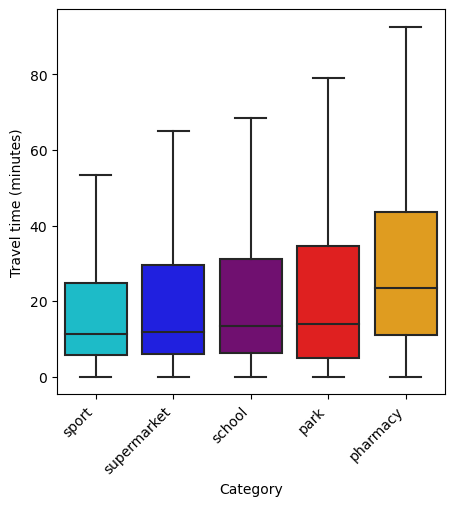

In [25]:
# SENSITIVITY ANALYSIS make boxplot of all categories
custom_colors = ['#00D3E5','blue','purple','red','orange', '#EAEA00']  

mean_travel_time = df.groupby('category')['travel_time'].mean().sort_values().index

plt.figure(figsize=(5,5))
sns.boxplot(data=df, x='category', y='travel_time', showfliers=False, order=mean_travel_time, palette=custom_colors)
#plt.title('Overall Travel Times by Category Denmark')
# align the x tick labels to the right
plt.xticks(rotation=45, ha='right')

plt.xlabel('Category')
plt.ylabel('Travel time (minutes)')

# save fig
plt.savefig('figures/aggregate_denmark_travel_time_boxplot.png', dpi=300, bbox_inches='tight')

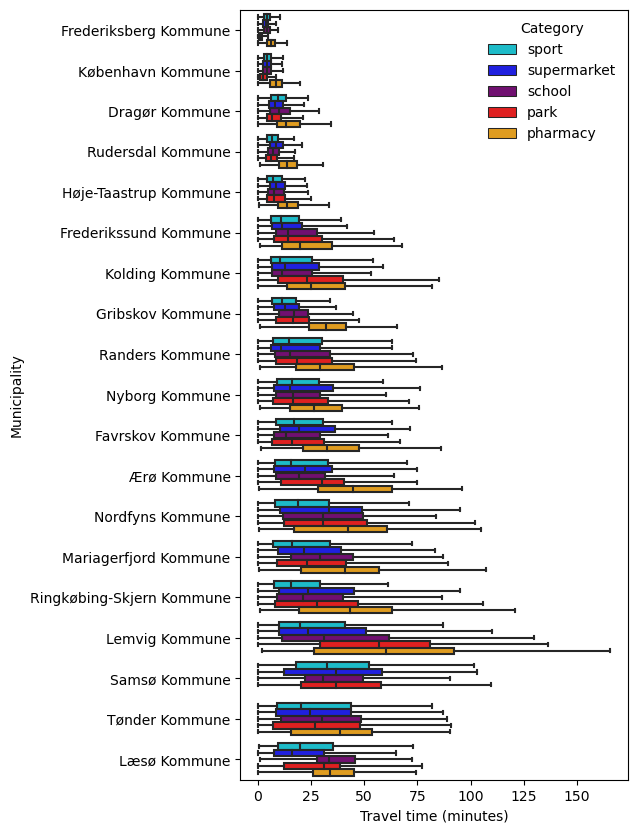

In [22]:
custom_colors = ['#00D3E5','blue','purple','red','orange', '#EAEA00']  

# plot a multi box plot where each category is a box centered around a municipality and hide outliers
plt.figure(figsize=(5,10))                     
sns.boxplot(data=df, x='travel_time', y='municipality', hue='category', showfliers=False, palette=custom_colors,
hue_order = ['sport', 'supermarket', 'school', 'park', 'pharmacy'])
plt.ylabel('Municipality')
#plt.title('Travel time to each category across Denmark')
plt.xlabel('Travel time (minutes)')
plt.legend(title='Category', frameon=False)

# save fig
plt.savefig('figures/denmark_travel_time_boxplot.png', dpi=300, bbox_inches='tight')

In [ ]:
# SENSITIVITY ANALYSIS make boxplot of all categories
custom_colors = ['#00D3E5','blue','purple','red','orange', '#EAEA00']  

mean_travel_time = df.groupby('category')['travel_time'].mean().sort_values().index

plt.figure(figsize=(5,5))
sns.boxplot(data=df, x='category', y='travel_time', showfliers=False, order=mean_travel_time, palette=custom_colors)
#plt.title('Overall Travel Times by Category Denmark')
# align the x tick labels to the right
plt.xticks(rotation=45, ha='right')

plt.xlabel('Category')
plt.ylabel('Travel time (minutes)')

# save fig
plt.savefig('figures/aggregate_denmark_travel_time_boxplot.png', dpi=300, bbox_inches='tight')

In [ ]:
cat_boxes = pd.DataFrame(results['Mariagerfjord Kommune']['all']).melt()
mean_travel_time = cat_boxes.groupby('variable')['value'].mean().sort_values().index
plt.figure(figsize=(5,5))
sns.boxplot(data=cat_boxes, x='variable', y='value', showfliers=False, order=mean_travel_time)
plt.title('Overall Travel Times for each Category')

In [ ]:
# return the category with the longest travel time for each h3 index
longest_travel = df[df.groupby('h3_index')['travel_time'].transform('max') == df['travel_time']]['category'].value_counts()
longest_travel

In [ ]:
# divide by the total number
longest_travel/longest_travel.sum()

In [ ]:
# NOTE
Sometimes 'walk + bike' seems to outperform 'all'. We think this is due to there being destinations which are only accessible via public transports (eg. airports).  When the walk + bike networks is unable to reach a destination, this value is not considered in the calculation. - we should check how many nans we are getting!

In [ ]:
sns.scatterplot(data=plotting_results, x='population_density', y='mean_farthest_travel_time', hue='graph')
# log scale the axes
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Population density log(people/km2)')
plt.ylabel('N-minute travel time log(minutes)')
plt.title('Population density vs N-minute travel time all graph types')

In [ ]:
# only all
plotting_results_all = plotting_results[plotting_results['graph']=='all']
sns.scatterplot(data=plotting_results_all, x='population_density', y='mean_farthest_travel_time', hue='graph')
# log scale the axes
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Population density log(people/km2)')
plt.ylabel('N-minute travel time log(minutes)')
plt.title('Population density vs N-minute travel time')

In [ ]:
# get df with all municipalities, hex indices, travel times, and categories
dfs = [pd.DataFrame(results["_".join(muni)]['all']).assign(
    municipality="_".join(muni)).reset_index()\
          for muni in municipalities]

df = pd.concat(dfs, ignore_index=True)

df.columns=['h3_index']+category_set+['municipality']
df = df.melt(id_vars=['h3_index','municipality'], var_name='category', value_name='travel_time')
df = df.merge(density_map, on='municipality')
df = df.sort_values(by='population_density', ascending=False)

In [ ]:
# plot a multi box plot where each category is a box centered around a municipality and hide outliers
plt.figure(figsize=(5,10))
sns.boxplot(data=df, x='travel_time', y='municipality', hue='category', showfliers=False)
plt.ylabel('Municipality (sorted by population density)')
plt.title('Travel time to each category across Denmark')

In [ ]:
# SENSITIVITY ANALYSIS make boxplot of all categories
mean_travel_time = df.groupby('category')['travel_time'].mean().sort_values().index

plt.figure(figsize=(5,5))
sns.boxplot(data=df, x='category', y='travel_time', showfliers=False, order=mean_travel_time)
plt.title('Overall Travel Times for each Category')

In [ ]:
# return the category with the longest travel time for each h3 index
df[df.groupby('h3_index')['travel_time'].transform('max') == df['travel_time']]['category'].value_counts()

In [ ]:
# plot a multi box plot where each category is a box centered around a municipality
plt.figure(figsize=(5,10))
sns.boxplot(data=df, x='travel_time', y='municipality', hue='category')

In [ ]:
for i in range(len(municipalities)):
    plot_accessibility(df, municipalities[i], 'supermarket')

In [ ]:
# get rows which contain a specific municipality
area = '_'.join(municipalities[0])
poi = 'supermarket'

# get rows which contain a specific municipality and category
plot_df = df[df['municipality'] == area]
plot_df = plot_df[plot_df['category'] == poi]

plot_df[['y','x']] = list(plot_df['h3_index'].apply(h3.h3_to_geo))
    # Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(plot_df, geometry=gpd.points_from_xy(plot_df.x, plot_df.y))

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, column='travel_time', categorical=False,
            legend=True, markersize=50, alpha=0.5, cmap='Reds',
            vmin=0, vmax=25)

destinations = pd.read_csv('../resources/destinations/'+area+'_destinations_clean.csv')
poi_df = destinations[destinations['category']==poi].copy()
poi_df[['y','x']] = list(poi_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(poi_df, geometry=gpd.points_from_xy(poi_df.x, poi_df.y))

# Show the GeoPandas DataFrame
gdf.plot(ax=ax, markersize=5, alpha=0.5)
plt.title(f"min travel time from residential areas (red) to supermarkets (in blue) {len(plot_df)} orgins")
cx.add_basemap(ax = ax, crs="EPSG:4326")

plt.savefig('figures/'+area+poi+'.png', dpi=300)

In [ ]:
# plot travel time on top of poi points
plot_df = pd.DataFrame([(p,k,v) for p in mins.keys() for k,v in mins[p].items()],
                        columns = ['poi_type','h3_index','mean_dist'])
plot_df = plot_df[plot_df['category']=='supermarket']
plot_df[['y','x']] = list(plot_df['h3_index'].apply(h3.h3_to_geo))
    # Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(plot_df, geometry=gpd.points_from_xy(plot_df.x, plot_df.y))

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, column='mean_dist', categorical=False,
            legend=True, markersize=50, alpha=0.5, cmap='Reds',
            vmin=0, vmax=25)

#plot poi points
poi_df = h3_df[h3_df['category']=='pharmacy'].copy()
poi_df[['y','x']] = list(poi_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(poi_df, geometry=gpd.points_from_xy(poi_df.x, poi_df.y))

# Show the GeoPandas DataFrame
gdf.plot(ax=ax, markersize=5, alpha=0.5)


#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)
plt.title("min travel time from residential areas (red) to supermarkets (in blue)")
cx.add_basemap(ax = ax, crs="EPSG:4326")

#plt.savefig('figures/supermarkets_1000.png', dpi=300)

In [ ]:
denmark_origins = df[['h3_index','municipality','population_density']].drop_duplicates()
denmark_origins['n_minute'] = denmark_origins['h3_index'].map(df.groupby('h3_index')['travel_time'].max())
# make violin plot where each municiaplity is a violin
# Increase figure size
plt.figure(figsize=(10, 15))

# Create the violin plot
sns.violinplot(data=denmark_origins, x='n_minute', y='municipality', showfliers=False, width=2)

# Adjust the y-axis limits
#plt.ylim(-1, len(denmark_origins['municipality'])+1)

In [ ]:
# turn category into multiple columns for each value of category
pivoted_df = df.pivot(index='h3_index', columns='category', values='travel_time').reset_index()
# add municipality and population density
pivoted_df = pivoted_df.merge(df[['h3_index','municipality','population_density']], on='h3_index')
pivoted_df
# 

In [ ]:
plot_df

In [ ]:
plot_accessibility(df, municipalities[-1], 'pharmacy')

In [ ]:
plot_accessibility(df, municipalities[-2], 'pharmacy')

In [ ]:
plot_accessibility(df, municipalities[5], 'pharmacy')

In [ ]:
for i in range(len(municipalities)):
    plot_accessibility(df, municipalities[i], 'supermarket')

In [ ]:
# get rows which contain a specific municipality
area = '_'.join(municipalities[0])
poi = 'supermarket'

# get rows which contain a specific municipality and category
plot_df = df[df['municipality'] == area]
plot_df = plot_df[plot_df['category'] == poi]

plot_df[['y','x']] = list(plot_df['h3_index'].apply(h3.h3_to_geo))
    # Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(plot_df, geometry=gpd.points_from_xy(plot_df.x, plot_df.y))

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, column='travel_time', categorical=False,
            legend=True, markersize=50, alpha=0.5, cmap='Reds',
            vmin=0, vmax=25)

destinations = pd.read_csv('../resources/destinations/'+area+'_destinations_clean.csv')
poi_df = destinations[destinations['category']==poi].copy()
poi_df[['y','x']] = list(poi_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(poi_df, geometry=gpd.points_from_xy(poi_df.x, poi_df.y))

# Show the GeoPandas DataFrame
gdf.plot(ax=ax, markersize=5, alpha=0.5)
plt.title(f"min travel time from residential areas (red) to supermarkets (in blue) {len(plot_df)} orgins")
cx.add_basemap(ax = ax, crs="EPSG:4326")

plt.savefig('figures/'+area+poi+'.png', dpi=300)

In [ ]:
# plot travel time on top of poi points
plot_df = pd.DataFrame([(p,k,v) for p in mins.keys() for k,v in mins[p].items()],
                        columns = ['poi_type','h3_index','mean_dist'])
plot_df = plot_df[plot_df['category']=='supermarket']
plot_df[['y','x']] = list(plot_df['h3_index'].apply(h3.h3_to_geo))
    # Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(plot_df, geometry=gpd.points_from_xy(plot_df.x, plot_df.y))

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, column='mean_dist', categorical=False,
            legend=True, markersize=50, alpha=0.5, cmap='Reds',
            vmin=0, vmax=25)

#plot poi points
poi_df = h3_df[h3_df['category']=='pharmacy'].copy()
poi_df[['y','x']] = list(poi_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(poi_df, geometry=gpd.points_from_xy(poi_df.x, poi_df.y))

# Show the GeoPandas DataFrame
gdf.plot(ax=ax, markersize=5, alpha=0.5)


#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)
plt.title("min travel time from residential areas (red) to supermarkets (in blue)")
cx.add_basemap(ax = ax, crs="EPSG:4326")

#plt.savefig('figures/supermarkets_1000.png', dpi=300)

In [ ]:
mins = results['_'.join(municipalities[0])]['all']

In [ ]:
sample_df = df.sample(1000) #df.sample(100)
sample_df[['y','x']] = list(sample_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
# geopandas.points_from_xy(x, y, z=None, crs=None)
gdf = gpd.GeoDataFrame(sample_df, geometry=gpd.points_from_xy(sample_df.x, sample_df.y))

fig, ax = plt.subplots(figsize=(10,10))
# Show the GeoPandas DataFrame
gdf.plot(ax=ax, column='category', categorical=True, legend=True, markersize=10, alpha=0.5)

# denmark
#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)

# middle east
#plt.ylim(12.391681,12.737388)
#plt.xlim(55.549206, 55.759991)

cx.add_basemap(ax = ax, crs="EPSG:4326")

In [ ]:
h3_df['hex_type'] = 'poi'
origins = pd.read_csv(h3_csv)
origins = origins[origins['residential_bool']==1]
origins['hex_type'] = 'building_type'
combined = origins[['h3_index','hex_type']].append(h3_df[['h3_index','hex_type']])

sample_df = combined.sample(1000) #df.sample(100)
sample_df[['y','x']] = list(sample_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(sample_df, geometry=gpd.points_from_xy(sample_df.x, sample_df.y))

fig, ax = plt.subplots(figsize=(10,10))
# Show the GeoPandas DataFrame
gdf.plot(ax=ax, column='hex_type', categorical=True, legend=True, markersize=5, alpha=0.5)

#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)

cx.add_basemap(ax = ax, crs="EPSG:4326")

In [ ]:
category_travel_time_means={}
category_travel_time_means[c] = np.nanmean(list(mins[c].values()))
category_travel_time_means

In [ ]:
# kde plot for travel times, grouped by layer
import seaborn as sns

# Set the color palette
colors = sns.color_palette("husl", len(category_set))

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Travel time (minutes)")
ax.set_title(f"min travel time kde by poi type for {len(origins)} origins")
ax.set_box_aspect(1)
ax.set_xlim(0, 60)
#ax.set_ylim(0, 0.06)

for i,c in enumerate(category_set):
    sns.kdeplot(list(mins[c].values()), color=colors[i], fill=True, alpha=0.5, ax=ax)

# Add a legend
labels = category_set
ax.legend(labels)

plt.savefig(f'figures/kde_pois_{len(origins)}_origins.png', dpi=300)

In [ ]:
# kde plot for travel times, grouped by layer
import seaborn as sns

# Set the color palette
colors = sns.color_palette("husl", len(category_set))

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Travel time (minutes)")
ax.set_title(f"min travel time histogram by poi type for {len(origins)} origins")
ax.set_box_aspect(1)
ax.set_xlim(0, 30)
#ax.set_ylim(0, 0.06)

for i,c in enumerate(category_set):
    plt.hist(list(mins[c].values()), alpha=0.5, bins=300)

# Add a legend
labels = category_set
ax.legend(labels)

plt.savefig(f'figures/hist_pois{len(origins)}_origins.png', dpi=300)

In [ ]:
# kde plot for travel times, grouped by layer
import seaborn as sns

# Set the color palette
colors = sns.color_palette("husl", len(category_set))

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.set_xlabel("index")
ax.set_ylabel("travel_time")
ax.set_title(f"min travel time scatter by poi type for {len(origins)} origins")
#ax.set_box_aspect(1)
ax.set_xlim(-1, 400)
ax.set_ylim(0, 0.06)

for i,c in enumerate(category_set):
    plt.scatter(range(len(mins[c].values())), np.sort(np.array(mins[c].values(), dtype=np.float64)), alpha=0.5)

# Add a legend
plt.yscale('log')
labels = category_set
ax.legend(labels)

plt.savefig(f'figures/scatter_pois{len(origins)}_origins.png', dpi=300)

In [ ]:
# kde plot for travel times, grouped by layer
import seaborn as sns

# Set the color palette
colors = sns.color_palette("husl", len(category_set))

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.set_xlabel("index")
ax.set_ylabel("travel_time")
ax.set_title(f"min travel time scatter by poi type for {len(origins)} origins")
#ax.set_box_aspect(1)
ax.set_xlim(-1, 400)
ax.set_ylim(1, 20)

for i,c in enumerate(category_set):
    plt.scatter(range(len(mins[c].values())), sorted(list(mins[c].values())), alpha=0.5)

# Add a legend
plt.yscale('log')
labels = category_set
ax.legend(labels)

plt.savefig(f'figures/scatter_pois{len(origins)}_origins.png', dpi=300)

In [ ]:
# kde plot for travel times, grouped by layer
import seaborn as sns

# Set the color palette
colors = sns.color_palette("husl", len(category_set))

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.set_xlabel("index")
ax.set_ylabel("travel_time")
ax.set_title(f"min travel time scatter by poi type for {len(origins)} origins")
#ax.set_box_aspect(1)
ax.set_xlim(150, 250)
ax.set_ylim(5, 15)

for i,c in enumerate(category_set):
    plt.scatter(range(len(mins[c].values())), np.sort(np.array(mins[c].values(), dtype=np.float64)), alpha=0.5)

# Add a legend
plt.yscale('log')
labels = category_set
ax.legend(labels)

plt.savefig(f'figures/scatter_pois{len(origins)}_origins.png', dpi=300)

In [ ]:
# plot travel time on top of poi points
plot_df = pd.DataFrame([(p,k,v) for p in mins.keys() for k,v in mins[p].items()],
                        columns = ['poi_type','h3_index','mean_dist'])
plot_df = plot_df[plot_df['poi_type']=='supermarket']
plot_df[['y','x']] = list(plot_df['h3_index'].apply(h3.h3_to_geo))
    # Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(plot_df, geometry=gpd.points_from_xy(plot_df.x, plot_df.y))

fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, column='mean_dist', categorical=False,
            legend=True, markersize=50, alpha=0.5, cmap='Reds',
            vmin=0, vmax=25)

#plot poi points
poi_df = h3_df[h3_df['category']=='pharmacy'].copy()
poi_df[['y','x']] = list(poi_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(poi_df, geometry=gpd.points_from_xy(poi_df.x, poi_df.y))

# Show the GeoPandas DataFrame
gdf.plot(ax=ax, markersize=5, alpha=0.5)


#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)
plt.title("min travel time from residential areas (red) to supermarkets (in blue)")
cx.add_basemap(ax = ax, crs="EPSG:4326")

#plt.savefig('figures/supermarkets_1000.png', dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

#plot poi points
poi_df = h3_df[h3_df['category'].isin(['school','supermarket'])].copy()
poi_df[['y','x']] = list(poi_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(poi_df, geometry=gpd.points_from_xy(poi_df.x, poi_df.y))

# Show the GeoPandas DataFrame
gdf.plot(ax=ax, column='category', markersize=5, alpha=0.5, legend=True)


#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)
plt.title("plot all schools and supermarkets")
cx.add_basemap(ax = ax, crs="EPSG:4326")

plt.savefig('figures/supermarkets_and_schools.png', dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

#plot poi points
poi_df = h3_df[h3_df['category'].isin(['pharmacy','sport'])].copy()
poi_df[['y','x']] = list(poi_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(poi_df, geometry=gpd.points_from_xy(poi_df.x, poi_df.y))

# Show the GeoPandas DataFrame
gdf.plot(ax=ax, column='category', markersize=5, alpha=0.5, legend=True)


#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)
plt.title("plot all sport areas and pharmacies")
cx.add_basemap(ax = ax, crs="EPSG:4326")

plt.savefig('figures/sport_and_pharmacy.png', dpi=300)

In [ ]:
plot_df = pd.DataFrame([(k,v) for k,v in mins.items()], columns = ['h3_index','mean_dist'])
plot_hex_df(plot_df, markersize=100, color_column='mean_dist')